In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files

In [3]:
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import datetime

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import plot_model


In [4]:
!mkdir files #put all outcomes in a file to later zip and download easily

In [5]:
num_train_pneumonia = len(os.listdir('drive/MyDrive/data/chest_xray/train/PNEUMONIA'))
num_train_normal = len(os.listdir('drive/MyDrive/data/chest_xray/train/NORMAL'))

num_val_pneumonia = len(os.listdir('drive/MyDrive/data/chest_xray/val/PNEUMONIA'))
num_val_normal = len(os.listdir('drive/MyDrive/data/chest_xray/val/NORMAL'))

num_test_pneumonia = len(os.listdir('drive/MyDrive/data/chest_xray/test/PNEUMONIA'))
num_test_normal = len(os.listdir('drive/MyDrive/data/chest_xray/test/NORMAL'))

num_train_pneumonia, num_train_normal, num_val_pneumonia, num_val_normal, num_test_pneumonia, num_test_normal


(3574, 1040, 311, 311, 390, 234)

In [6]:
data_dir = pathlib.Path('drive/MyDrive/data/chest_xray/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names = class_names[1:]
class_names

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [7]:
def view_random_image(target_dir, target_class):

  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + '/' + random_image[0])

  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}')

  return img

Image shape: (632, 1056)


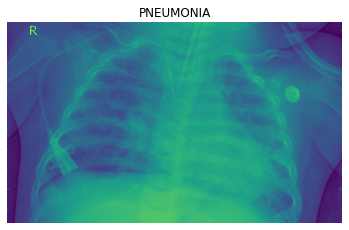

In [8]:
# Get 3 normal and 1 pneumonia images to see what they look like
img_p = view_random_image('drive/MyDrive/data/chest_xray/train/', 'PNEUMONIA')

Image shape: (885, 1188)


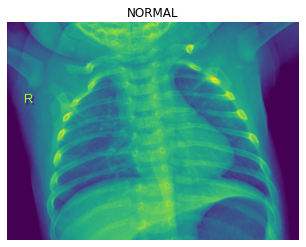

In [9]:
img_n1 = view_random_image('drive/MyDrive/data/chest_xray/train/', 'NORMAL')

Image shape: (1328, 1440)


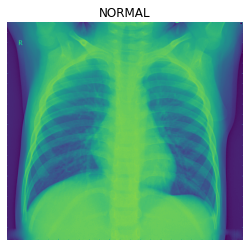

In [10]:
img_n2 = view_random_image('drive/MyDrive/data/chest_xray/train/', 'NORMAL')


Image shape: (1229, 1678)


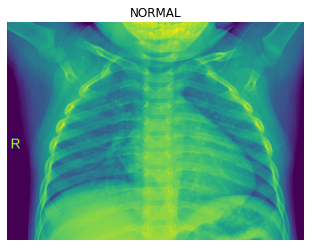

In [11]:
img_n3 = view_random_image('drive/MyDrive/data/chest_xray/train/', 'NORMAL')

### Our images are 2 dimensional

In [12]:
img_p, img_p.shape # we read our images as arrays

(array([[33, 35, 38, ..., 12, 12, 13],
        [33, 35, 38, ..., 12, 12, 13],
        [33, 35, 38, ..., 12, 12, 13],
        ...,
        [18, 18, 18, ..., 26, 27, 27],
        [18, 18, 18, ..., 26, 27, 27],
        [18, 18, 18, ..., 26, 27, 27]], dtype=uint8), (632, 1056))

In [13]:
tf.constant(img_p) # we can turn them into tensors 

<tf.Tensor: shape=(632, 1056), dtype=uint8, numpy=
array([[33, 35, 38, ..., 12, 12, 13],
       [33, 35, 38, ..., 12, 12, 13],
       [33, 35, 38, ..., 12, 12, 13],
       ...,
       [18, 18, 18, ..., 26, 27, 27],
       [18, 18, 18, ..., 26, 27, 27],
       [18, 18, 18, ..., 26, 27, 27]], dtype=uint8)>

In [14]:
SAVE_DIR = 'files/tensorboard'

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [15]:
def eval_model(model, data):
  '''
  Calculates model accuracy, precision, recall and f1 score for a binary classification model
  '''

  model_loss, model_accuracy, model_recall, model_precision = model.evaluate(data)
  model_results = {'loss':model_loss*100,
                   'accuracy':model_accuracy *100,
                   'recall':model_recall*100,
                   'precision':model_precision*100}

  return model_results

# PreProcessing the Data

In [16]:
tf.random.set_seed(42)

train_data_gen = ImageDataGenerator(rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

# Paths
train_dir = '/content/drive/MyDrive/data/chest_xray/train'
val_dir = '/content/drive/MyDrive/data/chest_xray/val'
test_dir = '/content/drive/MyDrive/data/chest_xray/test'

train_data = train_data_gen.flow_from_directory(directory=train_dir,
                            batch_size=32, # images are read as batches of 32
                            target_size=(224,224),
                            class_mode='binary',
                            seed=42,
                            color_mode='grayscale')
val_data = train_data_gen.flow_from_directory(directory=val_dir,
                            batch_size=32,
                            target_size=(224,224),
                            class_mode='binary',
                            seed=42,
                            color_mode='grayscale')
test_data = train_data_gen.flow_from_directory(directory=test_dir,
                            batch_size=32,
                            target_size=(224,224),
                            class_mode='binary',
                            seed=42,
                            color_mode='grayscale')

Found 4612 images belonging to 2 classes.
Found 620 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
len(train_data) #how many batches of data we have in the train data

145

In [18]:
train_data.next()

(array([[[[0.16862746],
          [0.16862746],
          [0.21176472],
          ...,
          [0.9490197 ],
          [0.89019614],
          [0.9490197 ]],
 
         [[0.1764706 ],
          [0.1764706 ],
          [0.14901961],
          ...,
          [0.9176471 ],
          [0.91372555],
          [0.9686275 ]],
 
         [[0.18431373],
          [0.18431373],
          [0.17254902],
          ...,
          [0.9333334 ],
          [0.95294124],
          [0.97647065]],
 
         ...,
 
         [[0.34901962],
          [0.427451  ],
          [0.5803922 ],
          ...,
          [0.89019614],
          [0.83921576],
          [0.81568635]],
 
         [[0.38823533],
          [0.5176471 ],
          [0.58431375],
          ...,
          [0.8705883 ],
          [0.8431373 ],
          [0.8705883 ]],
 
         [[0.44705886],
          [0.5764706 ],
          [0.60784316],
          ...,
          [0.8196079 ],
          [0.8196079 ],
          [0.81568635]]],
 
 
        [

In [19]:
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

Image shape: (469, 796, 3)
Image shape: (1187, 1534)


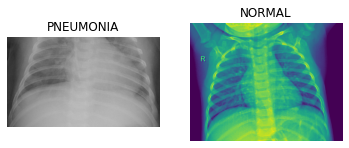

In [20]:
# Visualize the data
plt.figure()
plt.subplot(1,2,1)
pneumonia_img = view_random_image('drive/MyDrive/data/chest_xray/train/', 'PNEUMONIA')

plt.subplot(1,2,2)
normal_img = view_random_image('drive/MyDrive/data/chest_xray/train/', 'NORMAL')

 ## Baseline Model

In [21]:
tf.random.set_seed(42)

baseline_model = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=(224,224,1)),
    MaxPool2D(pool_size=2,
              padding='valid'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model

baseline_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy', Recall(), Precision()])

filepath1 = 'files/baseline_model'

checkpoint1 = ModelCheckpoint(filepath=filepath1,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks1 = [checkpoint1]

# Fit the model to train data

history_1 = baseline_model.fit(train_data, # we do not need x and y 
                               epochs=15,
                               steps_per_epoch=len(train_data),
                               validation_data=val_data,
                               validation_steps=len(val_data),
                               callbacks = [callbacks1,create_tensorboard_callback(SAVE_DIR,
                                                                   'baseline_model_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/baseline_model_tensorboard/20220413-205126
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8868 - recall: 0.9482 - precision: 0.9095 
Epoch 1: val_accuracy improved from -inf to 0.96774, saving model to files/baseline_model
INFO:tensorflow:Assets written to: files/baseline_model/assets
145/145 [==============================] - 3070s 21s/step - loss: 0.2878 - accuracy: 0.8868 - recall: 0.9482 - precision: 0.9095 - val_loss: 0.1348 - val_accuracy: 0.9677 - val_recall: 0.9613 - val_precision: 0.9739
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9649 - recall: 0.9787 - precision: 0.9760
Epoch 2: val_accuracy improved from 0.96774 to 0.97258, saving model to files/baseline_model
INFO:tensorflow:Assets written to: files/baseline_model/assets
145/145 [==============================] - 48s 330ms/step - loss: 0.1003 - accuracy: 0.9649 - recall: 0.9787 - pre

In [22]:
baseline_model = load_model(filepath1)
baseline_results = eval_model(baseline_model,test_data)
baseline_results

20/20 [==============================] - 433s 23s/step - loss: 0.9108 - accuracy: 0.7756 - recall: 0.9846 - precision: 0.7413


{'accuracy': 77.56410241127014,
 'loss': 91.07687473297119,
 'precision': 74.13127422332764,
 'recall': 98.46153855323792}

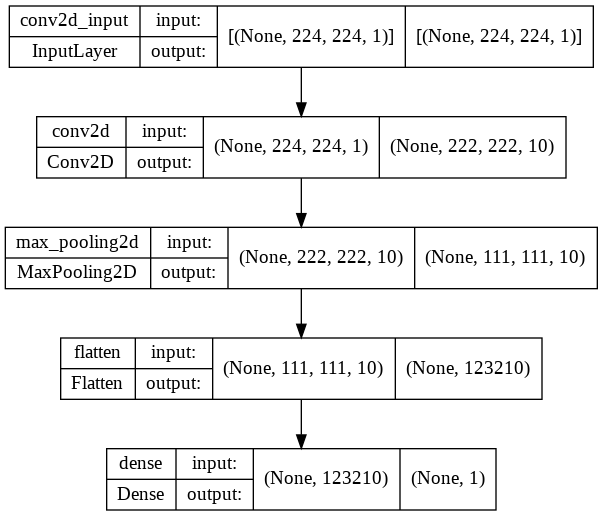

In [23]:
plot_model(baseline_model, show_shapes=True)

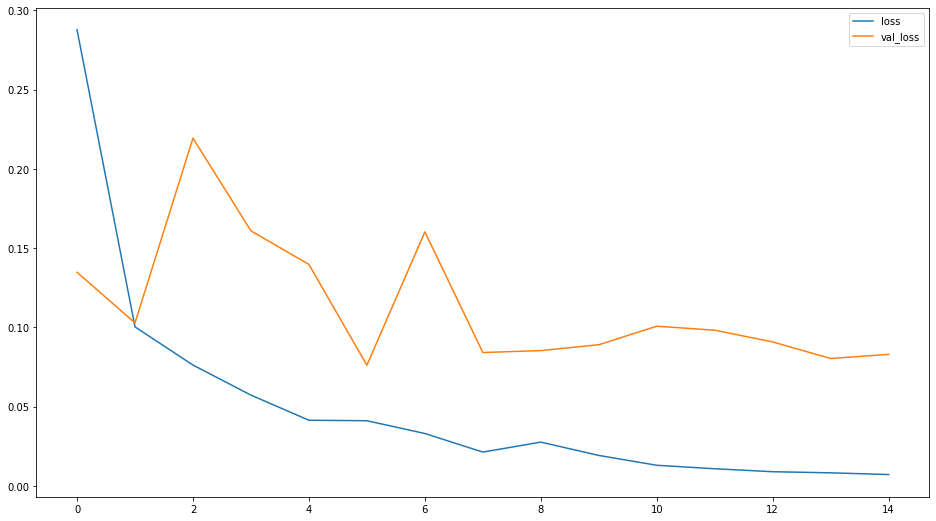

In [24]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot(figsize=(16,9));

## CNN Model

In [25]:
tf.random.set_seed(42)

cnn_model = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=(224,224,1)),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(pool_size=2,
              padding='valid'),
    Conv2D(10,3, activation='relu'),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model

cnn_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy', Recall(), Precision()])

filepath2 = 'files/cnn_model'

checkpoint2 = ModelCheckpoint(filepath=filepath2,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks2 = [checkpoint2]

# Fit the model to train data

history_2 = cnn_model.fit(train_data, # we do not need x and y 
                               epochs=15,
                               steps_per_epoch=len(train_data),
                               validation_data=val_data,
                               validation_steps=len(val_data),
                               callbacks = [callbacks2,create_tensorboard_callback(SAVE_DIR,
                                                                   'cnn_model_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/cnn_model_tensorboard/20220413-220129
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8641 - recall_1: 0.9659 - precision_1: 0.8723
Epoch 1: val_accuracy improved from -inf to 0.92419, saving model to files/cnn_model
INFO:tensorflow:Assets written to: files/cnn_model/assets
145/145 [==============================] - 51s 341ms/step - loss: 0.3081 - accuracy: 0.8641 - recall_1: 0.9659 - precision_1: 0.8723 - val_loss: 0.2029 - val_accuracy: 0.9242 - val_recall_1: 0.9839 - val_precision_1: 0.8790
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9657 - recall_1: 0.9812 - precision_1: 0.9747
Epoch 2: val_accuracy improved from 0.92419 to 0.96774, saving model to files/cnn_model
INFO:tensorflow:Assets written to: files/cnn_model/assets
145/145 [==============================] - 49s 335ms/step - loss: 0.0895 - accuracy: 0.9657 - recall_1: 0.9812 - precision_1

In [26]:
cnn_model = load_model(filepath2)
cnn_results = eval_model(cnn_model,test_data)
cnn_results

20/20 [==============================] - 5s 250ms/step - loss: 1.7810 - accuracy: 0.7724 - recall_1: 0.9923 - precision_1: 0.7357


{'accuracy': 77.24359035491943,
 'loss': 178.0961275100708,
 'precision': 73.57414364814758,
 'recall': 99.23076629638672}

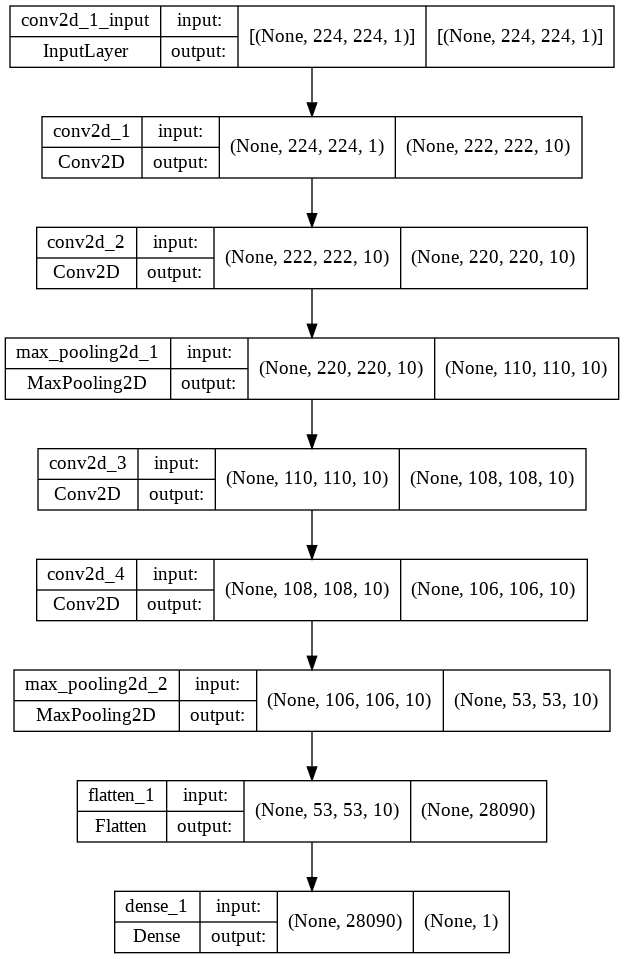

In [27]:
plot_model(cnn_model, show_shapes=True)

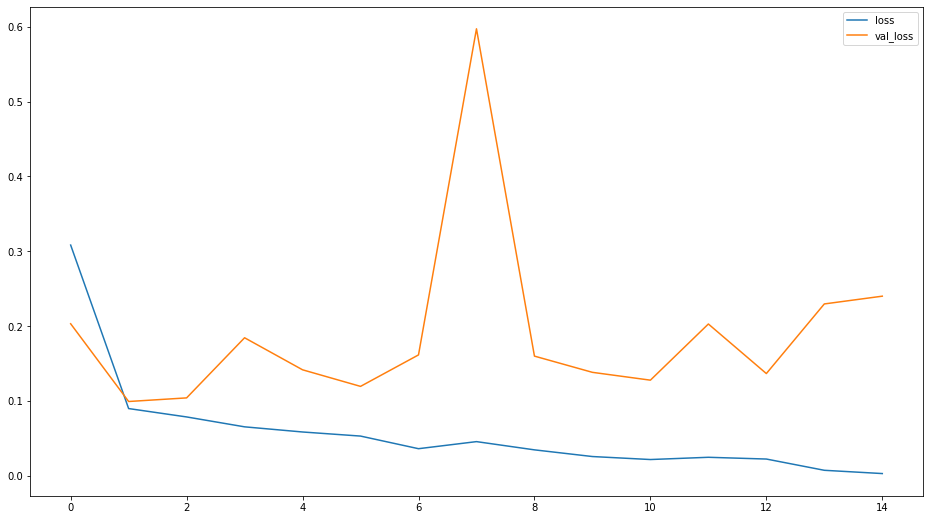

In [28]:
pd.DataFrame(history_2.history)[['loss','val_loss']].plot(figsize=(16,9));

## Flatten Only Model

In [29]:
tf.random.set_seed(42)

flatten_model = Sequential([
    Flatten(input_shape=(224,224,1)),
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

flatten_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy', Recall(), Precision()])

filepath3 = 'files/flatten_model'

checkpoint3 = ModelCheckpoint(filepath=filepath3,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks3 = [checkpoint3]

# Fit the model to train data

history_3 = flatten_model.fit(train_data, # we do not need x and y 
                               epochs=15,
                               steps_per_epoch=len(train_data),
                               validation_data=val_data,
                               validation_steps=len(val_data),
                               callbacks = [callbacks3,create_tensorboard_callback(SAVE_DIR,
                                                                   'flatten_model_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/flatten_model_tensorboard/20220413-224716
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.7650 - recall_2: 0.9846 - precision_2: 0.7737
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to files/flatten_model
INFO:tensorflow:Assets written to: files/flatten_model/assets
145/145 [==============================] - 49s 335ms/step - loss: 0.7044 - accuracy: 0.7650 - recall_2: 0.9846 - precision_2: 0.7737 - val_loss: 0.7016 - val_accuracy: 0.5000 - val_recall_2: 1.0000 - val_precision_2: 0.5000
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.7747 - recall_2: 1.0000 - precision_2: 0.7747
Epoch 2: val_accuracy did not improve from 0.50000
145/145 [==============================] - 48s 328ms/step - loss: 0.6032 - accuracy: 0.7747 - recall_2: 1.0000 - precision_2: 0.7747 - val_loss: 0.7306 - val_accuracy: 0.5000 - val_recall_2: 1.0000 - val_pre

In [30]:
flatten_model = load_model(filepath3)
flatten_results = eval_model(flatten_model, test_data)
flatten_results

20/20 [==============================] - 5s 237ms/step - loss: 0.6691 - accuracy: 0.6250 - recall_2: 1.0000 - precision_2: 0.6250


{'accuracy': 62.5,
 'loss': 66.90834164619446,
 'precision': 62.5,
 'recall': 100.0}

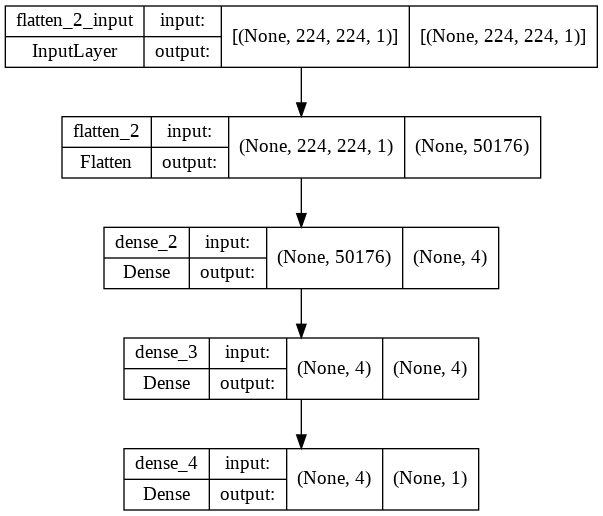

In [31]:
plot_model(flatten_model, show_shapes=True)

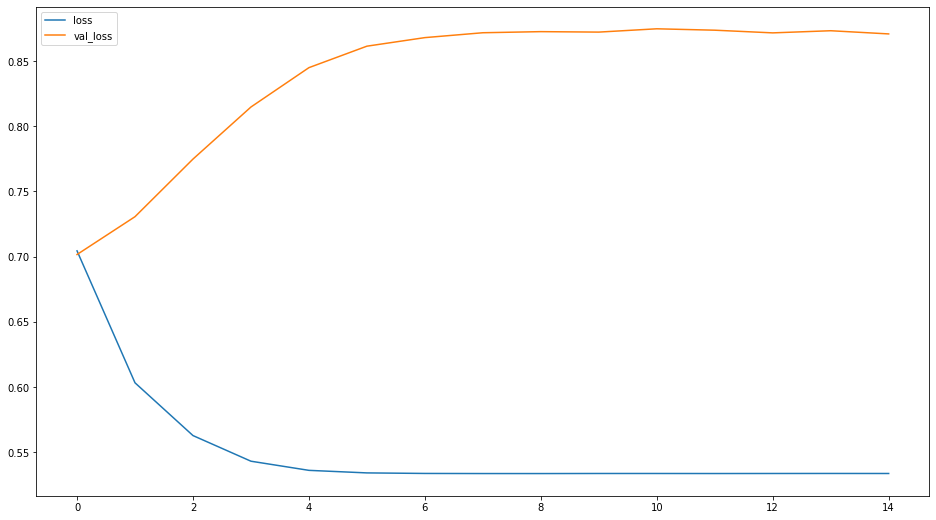

In [32]:
pd.DataFrame(history_3.history)[['loss','val_loss']].plot(figsize=(16,9));

## Flatten Model w/ more units

In [34]:
tf.random.set_seed(42)

flatten_model2 = Sequential([
    Flatten(input_shape=(224,224,1)),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

flatten_model2.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy', Recall(), Precision()])

filepath4 = 'files/flatten_model_2'

checkpoint4 = ModelCheckpoint(filepath=filepath4,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks4 = [checkpoint4]
# Fit the model to train data

history_4 = flatten_model2.fit(train_data, # we do not need x and y 
                               epochs=15,
                               steps_per_epoch=len(train_data),
                               validation_data=val_data,
                               validation_steps=len(val_data),
                               callbacks = [callbacks4,create_tensorboard_callback(SAVE_DIR,
                                                                   'flatten_model_2_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/flatten_model_2_tensorboard/20220413-230231
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.8465 - recall_4: 0.9160 - precision_4: 0.8892
Epoch 1: val_accuracy improved from -inf to 0.77419, saving model to files/flatten_model_2
INFO:tensorflow:Assets written to: files/flatten_model_2/assets
145/145 [==============================] - 50s 336ms/step - loss: 0.4917 - accuracy: 0.8465 - recall_4: 0.9160 - precision_4: 0.8892 - val_loss: 0.5363 - val_accuracy: 0.7742 - val_recall_4: 0.9935 - val_precision_4: 0.6906
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9196 - recall_4: 0.9544 - precision_4: 0.9425
Epoch 2: val_accuracy improved from 0.77419 to 0.90806, saving model to files/flatten_model_2
INFO:tensorflow:Assets written to: files/flatten_model_2/assets
145/145 [==============================] - 49s 336ms/step - loss: 0.1925 - accuracy: 0.9196 - 

In [35]:
flatten_model_2 = load_model(filepath4)
flatten_2_results = eval_model(flatten_model_2, test_data)

20/20 [==============================] - 5s 243ms/step - loss: 0.5266 - accuracy: 0.7853 - recall_4: 0.9667 - precision_4: 0.7570


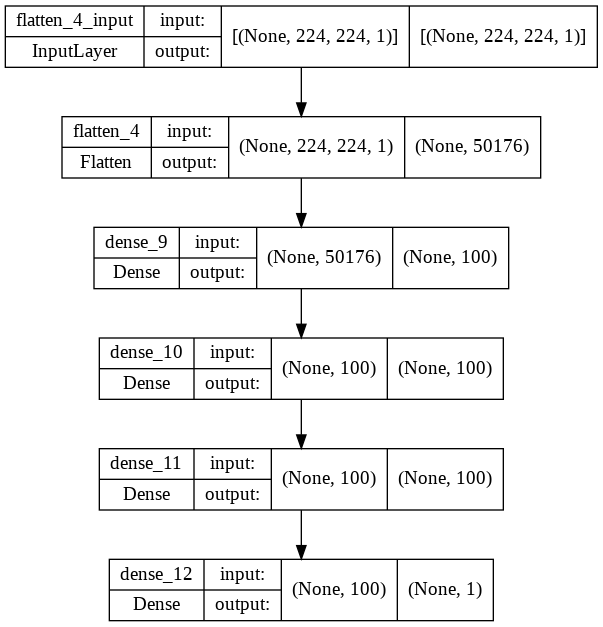

In [36]:
plot_model(flatten_model_2, show_shapes=True)

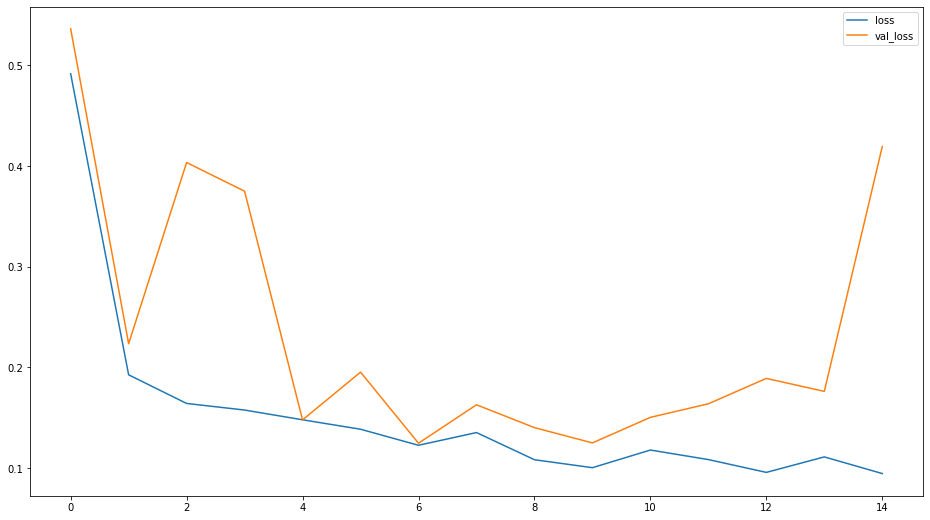

In [37]:
pd.DataFrame(history_4.history)[['loss','val_loss']].plot(figsize=(16,9));

### The models are doing a good job with recall but precision scores are not good. 

## Data Augmentation

In [38]:
tf.random.set_seed(42)

train_data_gen_augmented = ImageDataGenerator(rescale=1/255.,
                                              rotation_range=.2,
                                              shear_range=.2,
                                              zoom_range=.2,
                                              width_shift_range=.2,
                                              height_shift_range=.2,
                                              brightness_range=[.5, 1.5])

train_data_gen = ImageDataGenerator(rescale=1/255.)
val_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)


train_data_augmented = train_data_gen_augmented.flow_from_directory(directory=train_dir,
                                                                    batch_size=32, # images are read as batches of 32
                                                                    target_size=(224,224),
                                                                    class_mode='binary',
                                                                    #seed=42,
                                                                    shuffle=False,
                                                                    color_mode='grayscale')


train_data = train_data_gen.flow_from_directory(directory=train_dir,
                            batch_size=32, # images are read as batches of 32
                            target_size=(224,224),
                            class_mode='binary',
                            #seed=42,
                            shuffle=False,
                            color_mode='grayscale')

Found 4612 images belonging to 2 classes.
Found 4612 images belonging to 2 classes.


In [39]:
images, labels = train_data.next()
images_augmented, labels_augmented = train_data_augmented.next()

<Figure size 432x288 with 0 Axes>

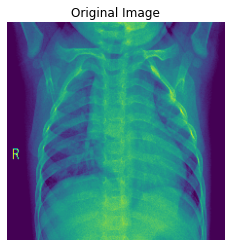

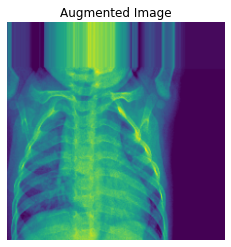

<Figure size 432x288 with 0 Axes>

In [40]:
random_number = np.random.randint(1,32) # There are 32 batches
plt.imshow(images[random_number].reshape(224,224))
plt.title('Original Image')
plt.axis(False)
plt.figure()
plt.imshow(images_augmented[random_number].reshape(224,224))
plt.title('Augmented Image')
plt.axis(False)
plt.figure()

<Figure size 432x288 with 0 Axes>

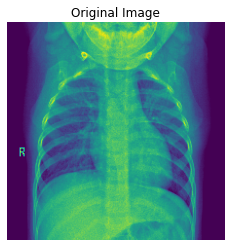

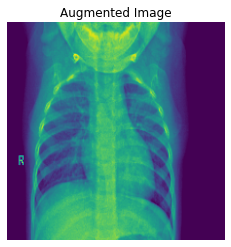

<Figure size 432x288 with 0 Axes>

In [41]:
random_number = np.random.randint(1,32) # There are 32 batches
plt.imshow(images[random_number].reshape(224,224))
plt.title('Original Image')
plt.axis(False)
plt.figure()
plt.imshow(images_augmented[random_number].reshape(224,224))
plt.title('Augmented Image')
plt.axis(False)
plt.figure()

<Figure size 432x288 with 0 Axes>

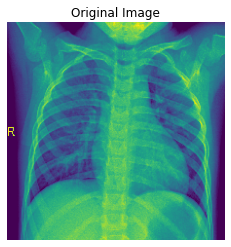

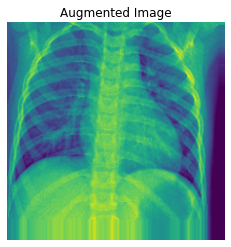

<Figure size 432x288 with 0 Axes>

In [42]:
random_number = np.random.randint(1,32) # There are 32 batches
plt.imshow(images[random_number].reshape(224,224))
plt.title('Original Image')
plt.axis(False)
plt.figure()
plt.imshow(images_augmented[random_number].reshape(224,224))
plt.title('Augmented Image')
plt.axis(False)
plt.figure()

## CNN Model w/ Augmented Train Data

In [43]:
tf.random.set_seed(42)

cnn_augmented_model = Sequential([
                                  Conv2D(filters=10,
                                        kernel_size=3,
                                        activation='relu',
                                        input_shape=(224,224,1)),
                                  Conv2D(10,3,activation='relu'),
                                  MaxPool2D(pool_size=2,
                                            padding='valid'),
                                  Conv2D(10,3, activation='relu'),
                                  Conv2D(10,3,activation='relu'),
                                  MaxPool2D(2),
                                  Flatten(),
                                  Dense(1, activation='sigmoid')
])

# Compile the model

cnn_augmented_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy', Recall(), Precision()])

filepath5 = 'files/cnn_augmented_model'

checkpoint5 = ModelCheckpoint(filepath=filepath5,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks5 = [checkpoint5]

# Fit the model to train data

history_5 = cnn_augmented_model.fit(train_data_augmented, # we do not need x and y 
                               epochs=15,
                               steps_per_epoch=len(train_data_augmented),
                               validation_data=val_data,
                               validation_steps=len(val_data),
                               callbacks = [callbacks5,create_tensorboard_callback(SAVE_DIR,
                                                                   'cnn_augmented_model_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/cnn_augmented_model_tensorboard/20220413-231822
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7667 - recall_5: 0.9871 - precision_5: 0.7740
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to files/cnn_augmented_model
INFO:tensorflow:Assets written to: files/cnn_augmented_model/assets
145/145 [==============================] - 66s 448ms/step - loss: 0.6169 - accuracy: 0.7667 - recall_5: 0.9871 - precision_5: 0.7740 - val_loss: 0.8310 - val_accuracy: 0.5000 - val_recall_5: 1.0000 - val_precision_5: 0.5000
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.7615 - recall_5: 0.9093 - precision_5: 0.8072
Epoch 2: val_accuracy improved from 0.50000 to 0.51129, saving model to files/cnn_augmented_model
INFO:tensorflow:Assets written to: files/cnn_augmented_model/assets
145/145 [==============================] - 64s 437ms/step - loss: 0.5961 -

In [44]:
cnn_augmented_model = load_model(filepath5)
cnn_augmented_results = eval_model(cnn_augmented_model, test_data)
cnn_augmented_results

20/20 [==============================] - 5s 252ms/step - loss: 0.4546 - accuracy: 0.7981 - recall_5: 0.8846 - precision_5: 0.8099


{'accuracy': 79.80769276618958,
 'loss': 45.461538434028625,
 'precision': 80.98591566085815,
 'recall': 88.46153616905212}

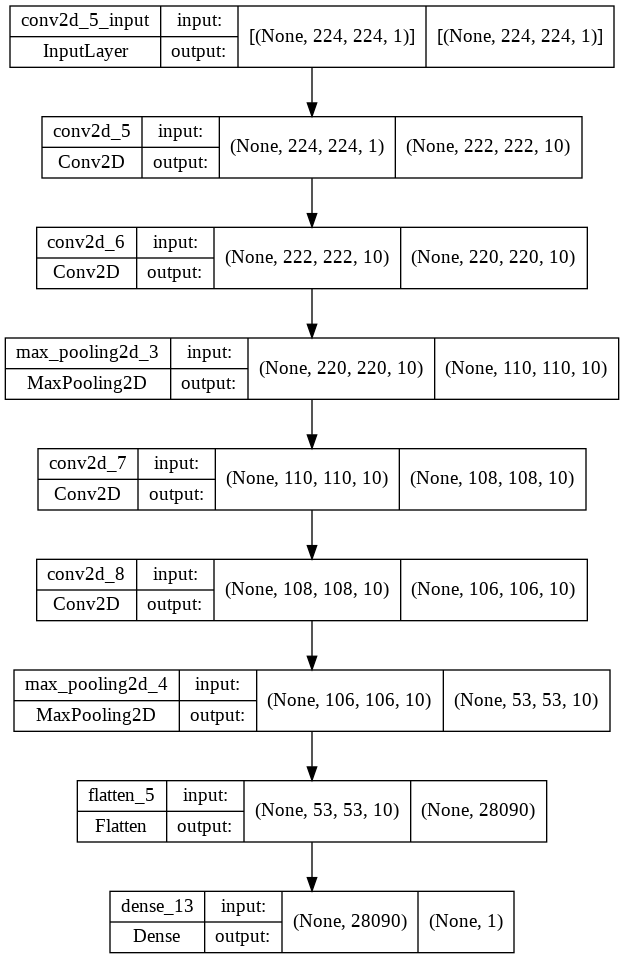

In [45]:
plot_model(cnn_augmented_model, show_shapes=True)

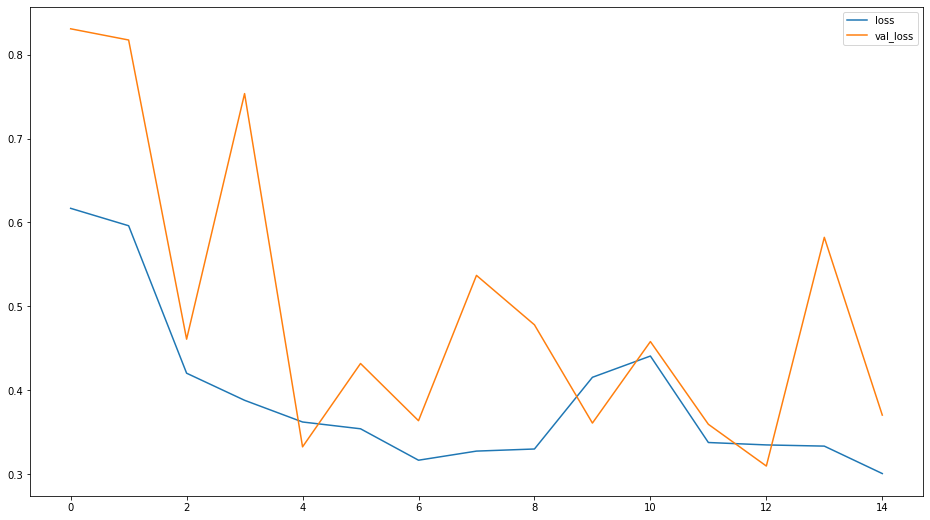

In [46]:
pd.DataFrame(history_5.history)[['loss','val_loss']].plot(figsize=(16,9));

## CNN Model w/ Augmented Shuffled Train Data

In [47]:
train_data_augmented2 = train_data_gen_augmented.flow_from_directory(directory=train_dir,
                                                                    batch_size=32, # images are read as batches of 32
                                                                    target_size=(224,224),
                                                                    class_mode='binary',
                                                                    seed=42,
                                                                    color_mode='grayscale')

Found 4612 images belonging to 2 classes.


In [48]:
tf.random.set_seed(42)

cnn_augmented_random_model = Sequential([
                                  Conv2D(filters=10,
                                        kernel_size=3,
                                        activation='relu',
                                        input_shape=(224,224,1)),
                                  Conv2D(10,3,activation='relu'),
                                  MaxPool2D(pool_size=2,
                                            padding='valid'),
                                  Conv2D(10,3, activation='relu'),
                                  Conv2D(10,3,activation='relu'),
                                  MaxPool2D(2),
                                  Flatten(),
                                  Dense(1, activation='sigmoid')
])

# Compile the model

cnn_augmented_random_model.compile(loss='binary_crossentropy',
                                    optimizer=tf.keras.optimizers.Adam(),
                                    metrics=['accuracy', Recall(), Precision()])

filepath6 = 'files/cnn_augmented_random_model'

checkpoint6 = ModelCheckpoint(filepath=filepath6,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks6 = [checkpoint6]

# Fit the model to train data

history_6 = cnn_augmented_random_model.fit(train_data_augmented2, # we do not need x and y 
                                epochs=15,
                                steps_per_epoch=len(train_data_augmented2),
                                validation_data=val_data,
                                validation_steps=len(val_data),
                                callbacks = [callbacks6,create_tensorboard_callback(SAVE_DIR,
                                                                   'cnn_augmented_random_model_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/cnn_augmented_random_model_tensorboard/20220413-233928
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8029 - recall_6: 0.9656 - precision_6: 0.8144
Epoch 1: val_accuracy improved from -inf to 0.72742, saving model to files/cnn_augmented_random_model
INFO:tensorflow:Assets written to: files/cnn_augmented_random_model/assets
145/145 [==============================] - 66s 449ms/step - loss: 0.4457 - accuracy: 0.8029 - recall_6: 0.9656 - precision_6: 0.8144 - val_loss: 0.4947 - val_accuracy: 0.7274 - val_recall_6: 0.9806 - val_precision_6: 0.6510
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8556 - recall_6: 0.9264 - precision_6: 0.8915
Epoch 2: val_accuracy improved from 0.72742 to 0.88710, saving model to files/cnn_augmented_random_model
INFO:tensorflow:Assets written to: files/cnn_augmented_random_model/assets
145/145 [==============================

In [49]:
cnn_augmented_random_model = load_model(filepath6)
cnn_augmented_random_results = eval_model(cnn_augmented_random_model, test_data)
cnn_augmented_random_results

20/20 [==============================] - 5s 241ms/step - loss: 0.4472 - accuracy: 0.7885 - recall_6: 0.9462 - precision_6: 0.7688


{'accuracy': 78.84615659713745,
 'loss': 44.71859931945801,
 'precision': 76.8750011920929,
 'recall': 94.61538195610046}

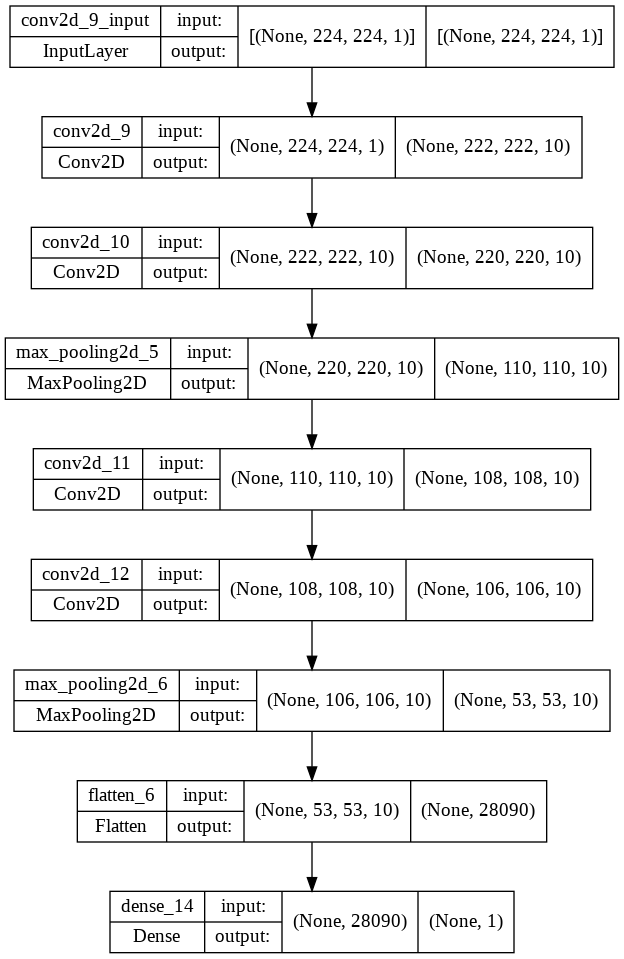

In [50]:
plot_model(cnn_augmented_random_model, show_shapes=True)

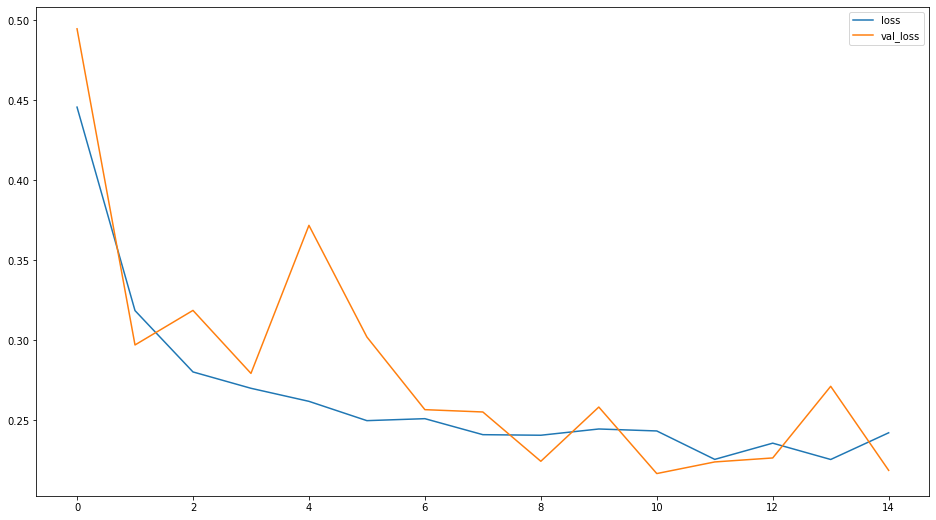

In [51]:
pd.DataFrame(history_6.history)[['loss','val_loss']].plot(figsize=(16,9));

## CNN Model w/ Augmented Train Data More Layers

In [52]:
tf.random.set_seed(42)

cnn_augmented_deeper_model = Sequential([
                                  Conv2D(filters=10,
                                        kernel_size=3,
                                        activation='relu',
                                        input_shape=(224,224,1)),
                                  Conv2D(10,3,activation='relu'),
                                  MaxPool2D(pool_size=2,
                                            padding='valid'),
                                  Dropout(0.2),
                                  Conv2D(10,3, activation='relu'),
                                  Conv2D(10,3,activation='relu'),
                                  MaxPool2D(2),
                                  Flatten(),
                                  Dense(128),
                                  Dropout(.2),
                                  Dense(1, activation='sigmoid')
])

# Compile the model

cnn_augmented_deeper_model.compile(loss='binary_crossentropy',
                                    optimizer=tf.keras.optimizers.Adam(),
                                    metrics=['accuracy', Recall(), Precision()])

filepath7 = 'files/cnn_augmented_deeper_model'

checkpoint7 = ModelCheckpoint(filepath=filepath7,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
callbacks7 = [checkpoint7]

# Fit the model to train data

history_7 = cnn_augmented_deeper_model.fit(train_data_augmented2, # we do not need x and y 
                                epochs=15,
                                steps_per_epoch=len(train_data_augmented2),
                                validation_data=val_data,
                                validation_steps=len(val_data),
                                callbacks = [callbacks7,create_tensorboard_callback(SAVE_DIR,
                                                                   'cnn_augmented_deeper_model_tensorboard') ]
                               )

Saving TensorBoard log files to: files/tensorboard/cnn_augmented_deeper_model_tensorboard/20220413-235632
Epoch 1/15
145/145 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.7684 - recall_7: 0.9468 - precision_7: 0.7939
Epoch 1: val_accuracy improved from -inf to 0.77742, saving model to files/cnn_augmented_deeper_model
INFO:tensorflow:Assets written to: files/cnn_augmented_deeper_model/assets
145/145 [==============================] - 66s 451ms/step - loss: 0.5141 - accuracy: 0.7684 - recall_7: 0.9468 - precision_7: 0.7939 - val_loss: 0.5046 - val_accuracy: 0.7774 - val_recall_7: 0.9484 - val_precision_7: 0.7067
Epoch 2/15
145/145 [==============================] - ETA: 0s - loss: 0.3469 - accuracy: 0.8445 - recall_7: 0.9339 - precision_7: 0.8740
Epoch 2: val_accuracy improved from 0.77742 to 0.85323, saving model to files/cnn_augmented_deeper_model
INFO:tensorflow:Assets written to: files/cnn_augmented_deeper_model/assets
145/145 [==============================

In [53]:
cnn_augmented_deep_model = load_model(filepath7)
cnn_augmented_deep_results = eval_model(cnn_augmented_deep_model, test_data)
cnn_augmented_deep_results

20/20 [==============================] - 5s 247ms/step - loss: 0.4357 - accuracy: 0.8061 - recall_7: 0.9667 - precision_7: 0.7773


{'accuracy': 80.60897588729858,
 'loss': 43.574318289756775,
 'precision': 77.7319610118866,
 'recall': 96.66666388511658}

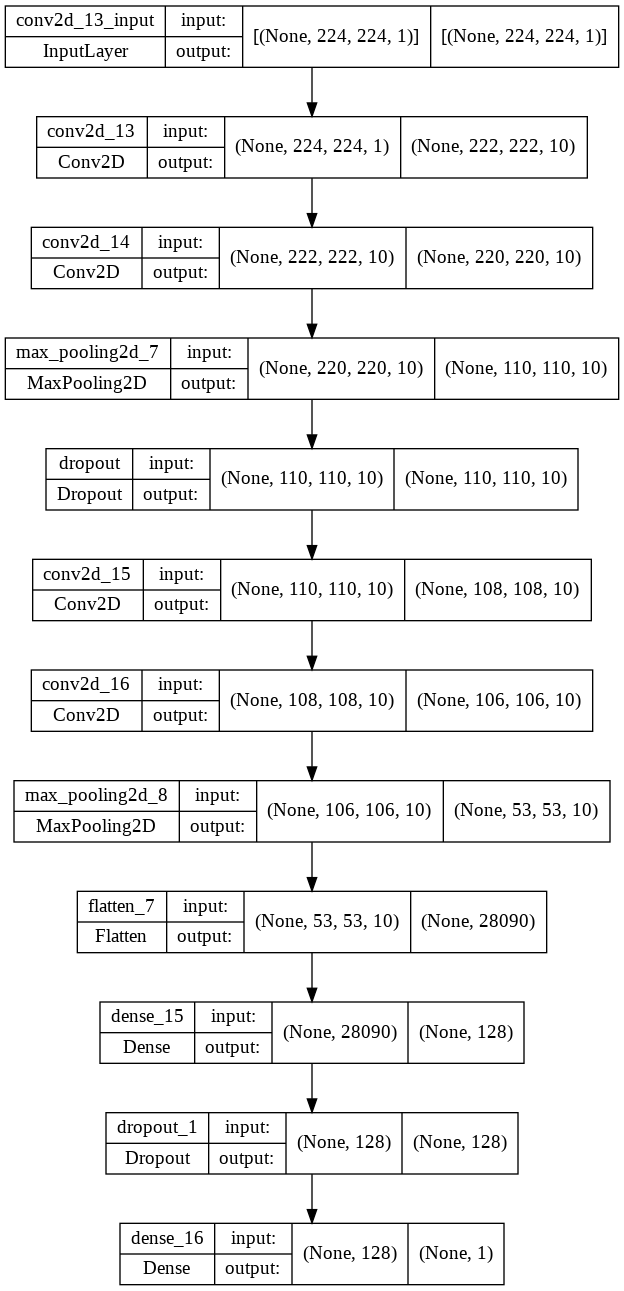

In [60]:
plot_model(cnn_augmented_deep_model, show_shapes=True)

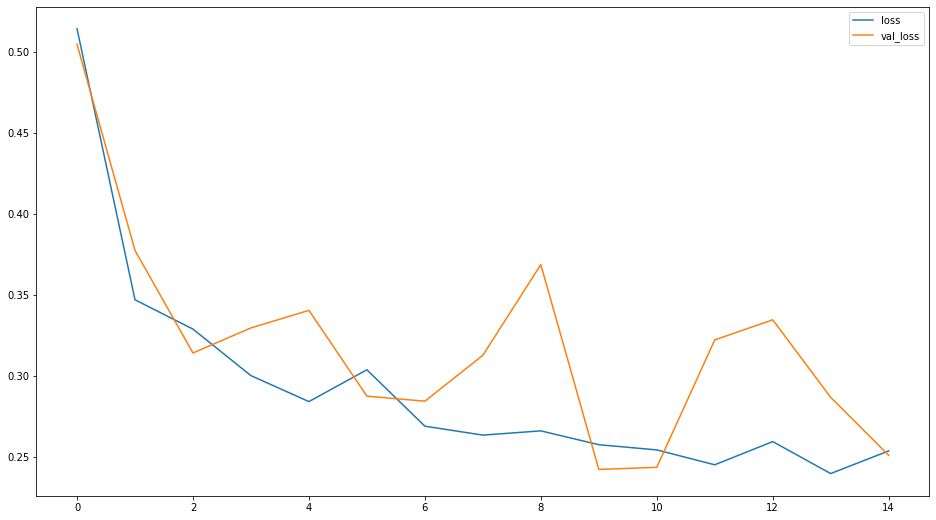

In [61]:
pd.DataFrame(history_7.history)[['loss','val_loss']].plot(figsize=(16,9));

In [56]:
all_model_results = pd.DataFrame({'Baseline CNN':baseline_results,
                                  'CNN':cnn_results,
                                  'Flatten': flatten_results,
                                  'Flatten_w/_more_units':flatten_2_results,
                                  'CNN Augmented':cnn_augmented_results,
                                  'CNN Augmented Random':cnn_augmented_random_results,
                                  'CNN Augmented Deep Model':cnn_augmented_deep_results
                                  })
                                  
all_model_results = all_model_results.T
all_model_results

,loss,accuracy,recall,precision
Baseline CNN,91.076875,77.564102,98.461539,74.131274
CNN,178.096128,77.243590,99.230766,73.574144
Flatten,66.908342,62.500000,100.000000,62.500000
Flatten_w/_more_units,52.656001,78.525639,96.666664,75.702810
CNN Augmented,45.461538,79.807693,88.461536,80.985916
CNN Augmented Random,44.718599,78.846157,94.615382,76.875001
CNN Augmented Deep Model,43.574318,80.608976,96.666664,77.731961


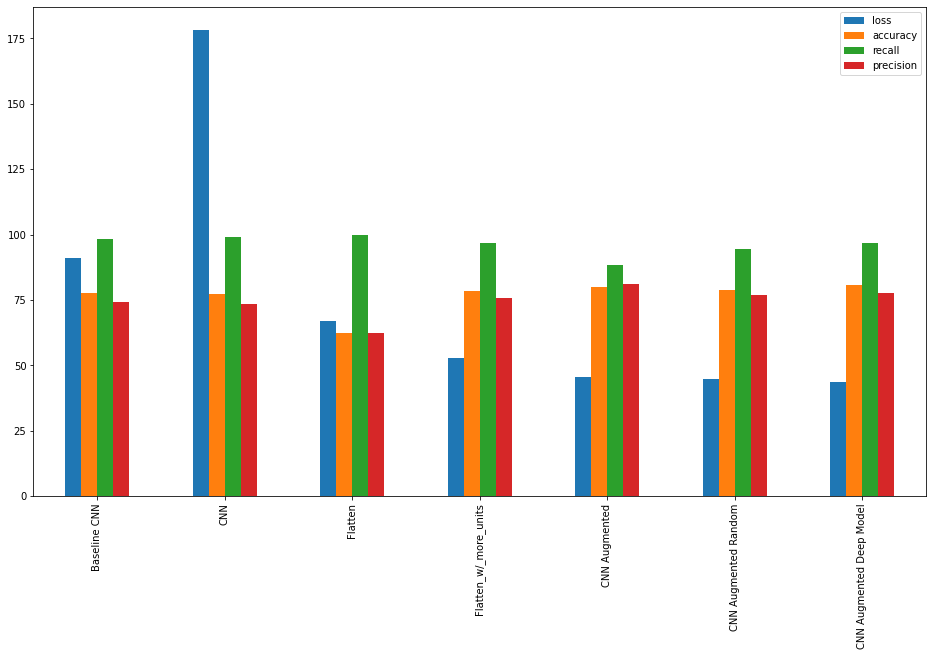

In [57]:
all_model_results.plot(kind='bar',figsize=(16,9)).legend(bbox_to_anchor=(1,1));

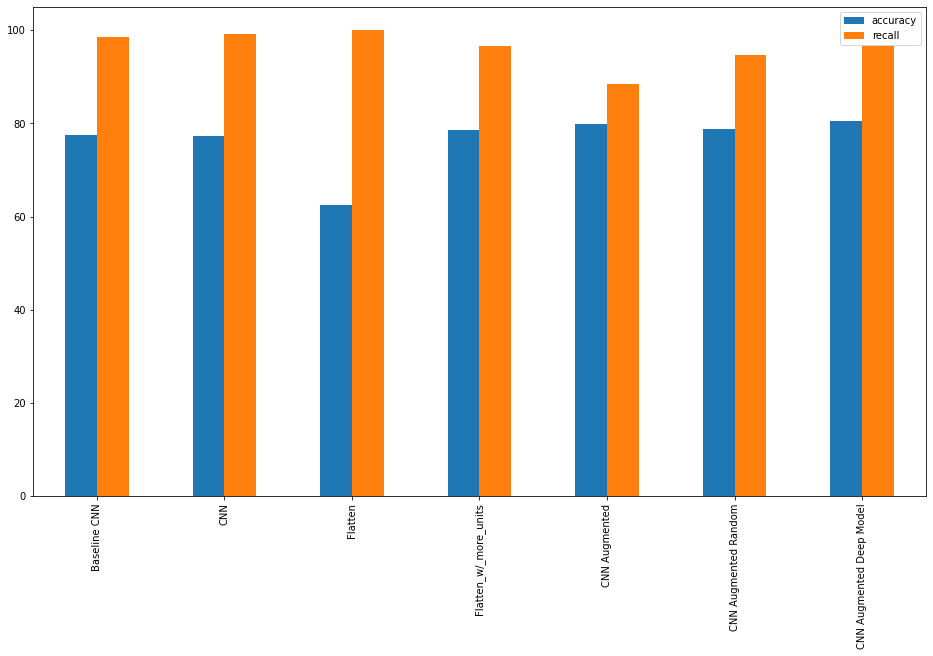

In [58]:
all_model_results[['accuracy','recall']].plot(kind='bar',figsize=(16,9));

In [ ]:
!tensorboard dev upload --logdir ./files/tensorboard/ \
  --name 'Pneumonia Detection Analysis' \
  --description 'Image Classification project of Pneumonia - X-ray Images' \
  --one_shot

Tensorboard Link

https://tensorboard.dev/experiment/JcJbt1qQSKCQVlLqoKRigw/

In [63]:
#Save all the files
!zip -r /content/file.zip /content/files/
files.download("/content/file.zip")

  adding: content/files/ (stored 0%)
  adding: content/files/cnn_augmented_model/ (stored 0%)
  adding: content/files/cnn_augmented_model/keras_metadata.pb (deflated 91%)
  adding: content/files/cnn_augmented_model/saved_model.pb (deflated 89%)
  adding: content/files/cnn_augmented_model/variables/ (stored 0%)
  adding: content/files/cnn_augmented_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/files/cnn_augmented_model/variables/variables.index (deflated 69%)
  adding: content/files/cnn_augmented_model/assets/ (stored 0%)
  adding: content/files/flatten_model_2/ (stored 0%)
  adding: content/files/flatten_model_2/keras_metadata.pb (deflated 89%)
  adding: content/files/flatten_model_2/saved_model.pb (deflated 89%)
  adding: content/files/flatten_model_2/variables/ (stored 0%)
  adding: content/files/flatten_model_2/variables/variables.data-00000-of-00001 (deflated 37%)
  adding: content/files/flatten_model_2/variables/variables.index (deflated 66%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>